In [1]:
from src.tensor import Tensor
import src.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from mnist import MNIST
np.set_printoptions(suppress=True)

In [2]:
mndata = MNIST('./mnist_dataset/')
mndata.gz = True
mnist_x_train, mnist_y_train = mndata.load_training()
mnist_x_test, mnist_y_test = mndata.load_testing()

In [3]:
x_train = Tensor(list(mnist_x_train))
x_test = Tensor(list(mnist_x_test))
y_train = Tensor(list(mnist_y_train))
y_test = Tensor(list(mnist_y_test))

In [4]:
rng = np.random.default_rng(seed=1)

In [5]:
# Scale down pixels from 0-255 to 0-1
x_train = x_train / 255
x_test = x_test / 255

# OneHot label vectors
def onehot(vector):
    tmp = []
    for scalar in vector.data:
        tmp2 = [1 if i==scalar else 0 for i in range(10)]
        tmp.append(tmp2)
    return Tensor(tmp)
y_train = onehot(y_train)
y_test = onehot(y_test)

print(f'x_train={x_train.shape}, y_train={y_train.shape}')
print(f'x_test={x_test.shape}, y_test={y_test.shape}')

x_train=(60000, 784), y_train=(60000, 10)
x_test=(10000, 784), y_test=(10000, 10)


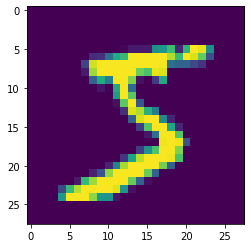

In [6]:
# Visualize X
img = np.array(x_train[0].tolist())
plt.imshow(img.reshape(28, 28))
plt.show()

In [7]:
# Multinomial sampling with replacement
def draw_batch(batch_size): 
    draw = lambda: int(rng.random() * x_train.shape[0])
    batch = [draw() for _ in range(batch_size)]
    return x_train[batch], y_train[batch]

In [35]:
mlp = nn.MLP(inputs=784, hidden=[600, 300], outs=10)
losses = []

In [36]:
epochs = 100
batch_size = 100
lr = 0.1
for e in range(epochs):
    x, y = draw_batch(batch_size)
    out = mlp(x)

    loss = nn.nlll(out, y, reduction='mean')

    loss.backward()
    mlp.train(lr=lr)

    losses.append(loss.data.item())
    print(f'Epoch {e}: {loss.data.item()}')

Epoch 0: 26.310624927361506
Epoch 1: 24.909620910809334
Epoch 2: 21.940845228899793
Epoch 3: 24.61615850058287
Epoch 4: 19.078826881652308
Epoch 5: 20.41296457712066
Epoch 6: 18.82678100795623
Epoch 7: 17.063125322057665
Epoch 8: 17.34796511990998
Epoch 9: 18.236210607057405
Epoch 10: 18.444794996676453
Epoch 11: 15.794871084369836
Epoch 12: 13.718653638949043
Epoch 13: 9.253617140694349
Epoch 14: 14.220855165738513
Epoch 15: 15.99850359644722
Epoch 16: 15.621354742613628
Epoch 17: 11.249628705493656
Epoch 18: 12.037060326157917
Epoch 19: 11.45391187283607
Epoch 20: 12.813618289629742
Epoch 21: 11.132772609485961
Epoch 22: 11.281720955443138
Epoch 23: 13.474264103571738
Epoch 24: 9.219595948809518
Epoch 25: 11.522573630514819
Epoch 26: 10.67156906128589
Epoch 27: 10.069189106333926
Epoch 28: 9.201256483353227
Epoch 29: 11.370195540484659
Epoch 30: 8.995043226860506
Epoch 31: 7.01907602620383
Epoch 32: 7.772052430074092
Epoch 33: 11.190172527307691
Epoch 34: 9.435889840567961
Epoch 35: 

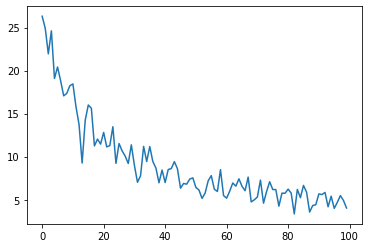

In [37]:
plt.plot(losses)
plt.show()

In [38]:
correct = 0
for i in range(len(x_test.data)):
    y = y_test[i]
    x = mlp(x_test[i])
    corr = np.argmax(y.data)
    predicted = np.argmax(x.data)
    if predicted == corr: correct += 1

print(f'Test accuracy: {(correct/len(x_test.data))*100}%')

Test accuracy: 62.74999999999999%
